In [1]:
from vivarium.core.process import Process
from vivarium.core.store import Store
from vivarium.core.engine import Engine, pp
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_variables

# Load the required components

To run an E. coli model, you need a few things:
 * **sim_data**: the model parameters from wcEcoli.
 * **initial_state**: the initial state of the system -- a snapshot from wcEcoli.
 * **processes**: the modular processes, which are wired together to create the full model.

## load sim_data

In [2]:
from ecoli.library.sim_data import LoadSimData

SIM_DATA_PATH = '../reconstruction/sim_data/kb/simData.cPickle'

load_sim_data = LoadSimData(
            sim_data_path=SIM_DATA_PATH,
            seed=0)

## load specific process parameters from sim_data

In [3]:
transcript_initiation_params = load_sim_data.get_transcript_initiation_config()
transcript_elongation_params = load_sim_data.get_transcript_elongation_config()

## get initial state snapshot

In [4]:
from ecoli.composites.ecoli_master import get_state_from_file

INITIAL_STATE_PATH = '../data/wcecoli_t0.json'

initial_state = get_state_from_file(path=INITIAL_STATE_PATH)

# Make processes by loading in parameters

In [5]:
from ecoli.processes.transcript_initiation import TranscriptInitiation
from ecoli.processes.transcript_elongation import TranscriptElongation

transcript_initiation = TranscriptInitiation(transcript_initiation_params)
transcript_elongation = TranscriptElongation(transcript_elongation_params)

## view a process' ports schema
The port schema defines a systems ports (top-level keys), and the expected behavior of molecules under that port (its *schema*).

In [6]:
pp(transcript_initiation.ports_schema())

{ 'RNAs': { '*': { 'RNAP_index': {'_default': 0, '_updater': 'set'},
                   'TU_index': {'_default': 0, '_updater': 'set'},
                   'can_translate': {'_default': 0, '_updater': 'set'},
                   'is_full_transcript': {'_default': 0, '_updater': 'set'},
                   'is_mRNA': {'_default': 0, '_updater': 'set'},
                   'transcript_length': { '_default': 0,
                                          '_emit': True,
                                          '_updater': 'set'},
                   'unique_index': {'_default': 0, '_updater': 'set'}}},
  'active_RNAPs': { '*': { 'coordinates': { '_default': 0,
                                            '_emit': True,
                                            '_updater': 'set'},
                           'direction': {'_default': 0, '_updater': 'set'},
                           'domain_index': {'_default': 0, '_updater': 'set'},
                           'unique_index': {'_default': 0, '_up

## run an individual process with minimal parameter set
A nice aspect of process modularity is that each can be configured with parameters that are not dependent on `sim_data`, and an arbitrary initial state. This supports easy access to parameters, which can be directly modified by learning algorithms.


Simulation ID: 36bbe800-daa3-11eb-815e-acde48001122
Created: 07/01/2021 at 12:33:29
Completed in 0.002460 seconds

simulation output:
{ 'A': [10, 25, 18, 21, 18, 17, 19, 14, 28, 22, 33, 18, 25, 20, 17, 20],
  'B': [20, 14, 23, 15, 19, 20, 26, 21, 15, 17, 13, 22, 23, 23, 24, 21],
  'C': [30, 21, 19, 24, 23, 23, 15, 25, 17, 21, 14, 20, 12, 17, 19, 19]}


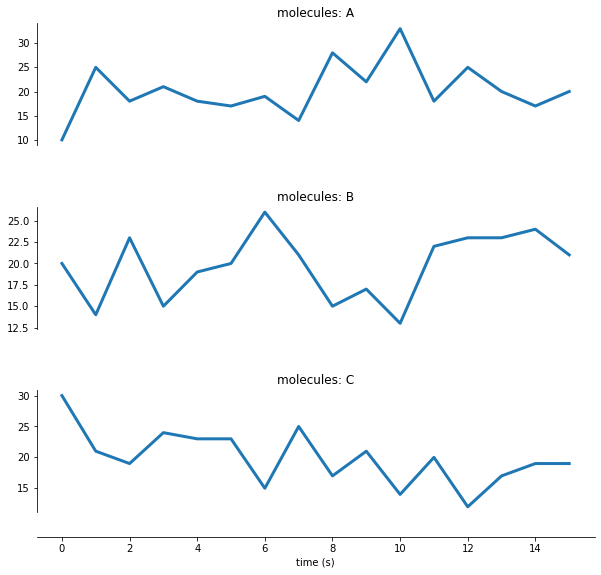

In [7]:
import numpy as np
from vivarium.core.composition import simulate_process
from ecoli.processes.complexation import Complexation

# define parameters
test_params = {
    'stoichiometry': np.array([
        [-1, 1, 0],
        [0, -1, 1],
        [1, 0, -1],
        [-1, 0, 1],
        [1, -1, 0],
        [0, 1, -1]], np.int64),
    'rates': np.array([1, 1, 1, 1, 1, 1], np.float64),
    'molecule_names': ['A', 'B', 'C'],
    'seed': 1}

# define initial state
initial_complexation_state = {
    'molecules': {
        'A': 10,
        'B': 20,
        'C': 30}}

# initialize the process
complexation_process = Complexation(test_params)

# run simulation and retrieve final data
settings = {
    'total_time': 15,
    'initial_state': initial_complexation_state}
data = simulate_process(complexation_process, settings)

print('\nsimulation output:')
pp(data['molecules'])

# plot output
fig = plot_variables(
    data, 
    variables=[
        ('molecules', 'A'), 
        ('molecules', 'B'), 
        ('molecules', 'C')],
    column_width=10, row_height=3, row_padding=0.5)

# Compose a multiscale model

In [8]:
from ecoli.composites.ecoli_master import ECOLI_TOPOLOGY

# create an empty "cell" store
cell = Store({})

# generate a path and add a process in the leaf
cell.create(
    ['cytoplasm', 'transcript_initiation'], 
    transcript_initiation, 
    topology=ECOLI_TOPOLOGY['transcript_initiation'])

cell.create(
    ['cytoplasm', 'transcript_elongation'], 
    transcript_elongation, 
    topology=ECOLI_TOPOLOGY['transcript_elongation'])

In [9]:
pp(cell.get_value())

{ 'cytoplasm': { 'transcript_elongation': <ecoli.processes.transcript_elongation.TranscriptElongation object at 0x1100c9070>,
                 'transcript_initiation': <ecoli.processes.transcript_initiation.TranscriptInitiation object at 0x136332a60>}}


## put the model in an Engine

In [10]:
# cell_experiment = Engine({'store': cell})

## run the simulation

In [11]:
# total_time = 10
# cell_experiment.update(total_time)

## retrieve the data

In [12]:
# # in "data" format with keys for each time step and emitted states as values
# data = cell_experiment.emitter.get_data()

# # in "timeseries" format with keys for the states, and a timeseries list as values
# timeseries = cell_experiment.emitter.get_data()

# Ecoli master composite

## load the composer
 * A `Composer` is a class that generates `Composite` models, with many processes wired together through shared `Stores`.
 * `Ecoli` is the current master composite of the E. coli model.

In [13]:
from ecoli.composites.ecoli_master import Ecoli

ecoli_config = {
    'agent_id': '1',
    '_schema': {
        'equilibrium': {
            'molecules': {
                'PD00413[c]': {
                    '_updater': 'nonnegative_accumulate'
                }
            }
        }
    },
    'sim_data_path': SIM_DATA_PATH}
ecoli_composer = Ecoli(ecoli_config)

## plot Ecoli's topology

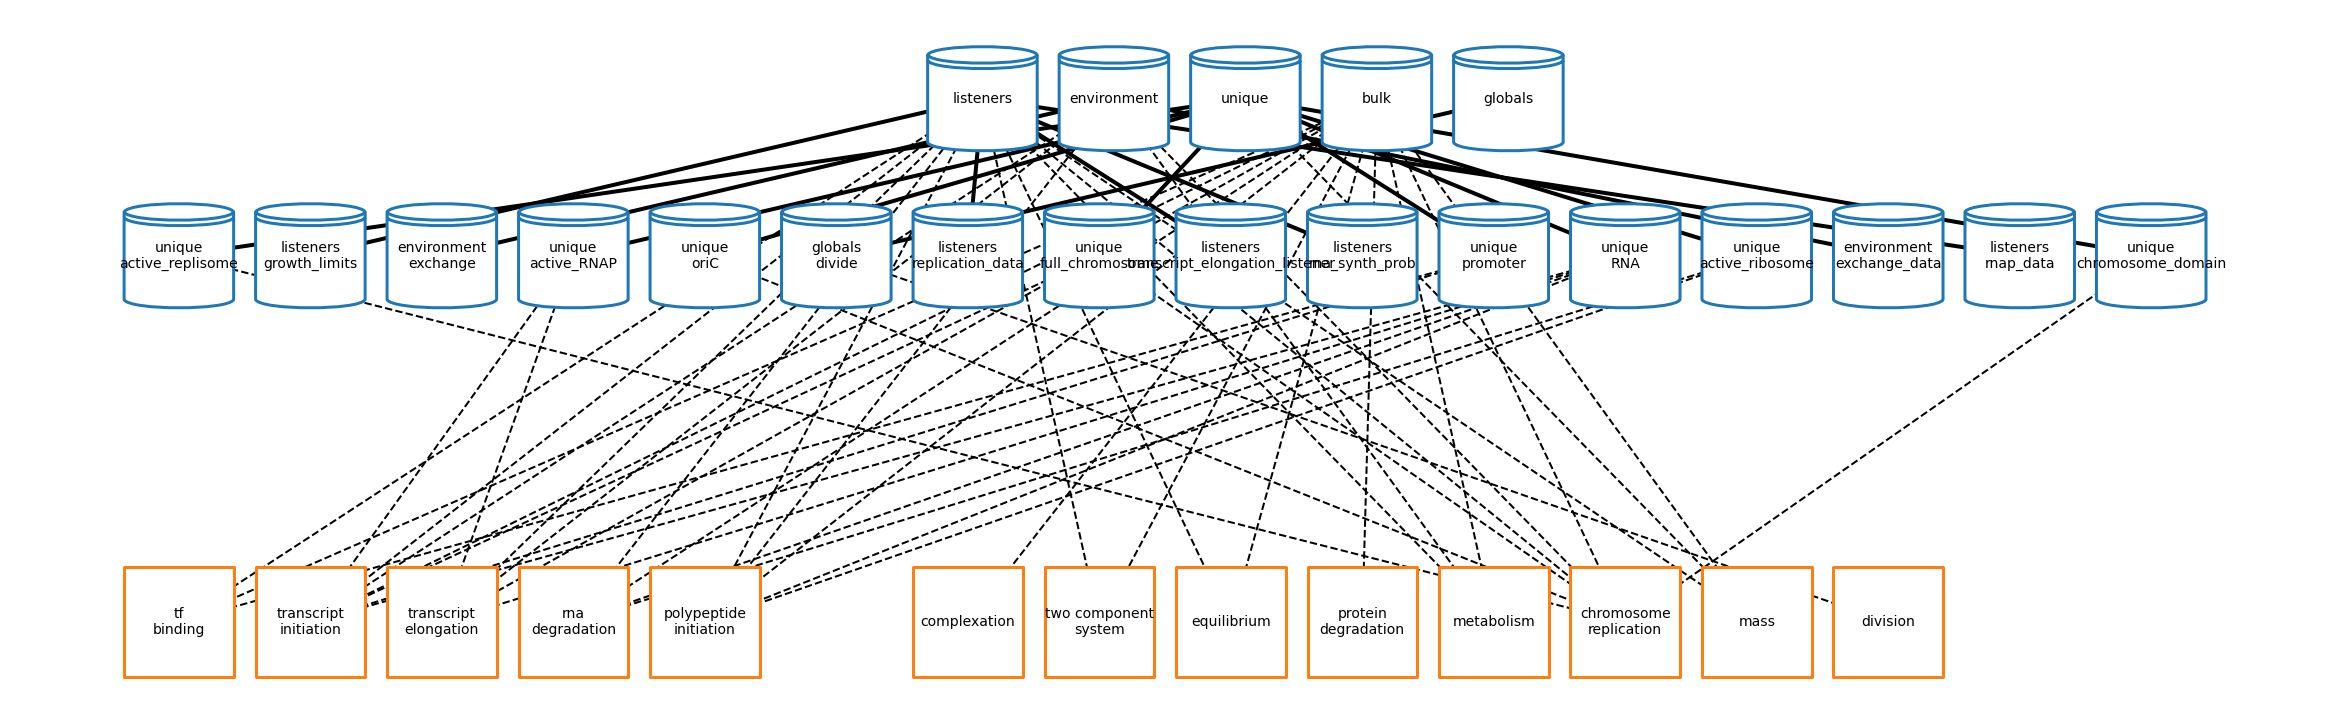

In [14]:
from ecoli.composites.ecoli_master import ecoli_topology_plot
topology_plot = ecoli_topology_plot(config=ecoli_config)

# initialize the simulation

In [15]:
ecoli = ecoli_composer.generate()
ecoli_simulation = Engine({
    'processes': ecoli.processes,
    'topology': ecoli.topology,
    'initial_state': initial_state,
    'progress_bar': True,
})


Simulation ID: 3ca46d82-daa3-11eb-815e-acde48001122
Created: 07/01/2021 at 12:33:41


/Users/eranagmon/.pyenv/versions/3.8.3/envs/vivarium_ecoli/lib/python3.8/site-packages/vivarium/core/engine.py:362: UserWarning: configuration size is too big for the emitter, discarding process parameters
  warnings.warn('configuration size is too big for the emitter, '


## run the simulation

In [16]:
total_time = 10
ecoli_simulation.update(total_time)

Progress:|██████████████████████████████████████████████████| 0.0/10.0 simulated seconds remaining    
Completed in 13.55 seconds


## examine output

In [17]:
# retrieve the data
ecoli_sim_data = ecoli_simulation.emitter.get_data(query={'listeners': 'mass'})

TypeError: get_data() got an unexpected keyword argument 'query'

In [ ]:
pp(ecoli_sim_data[0.0]['listeners']['mass'])

In [ ]:
# retrieve the data
ecoli_sim_output = ecoli_simulation.emitter.get_timeseries(fields={})

In [ ]:
ecoli_sim_output['listeners']['mass']

In [ ]:
# retrieve the data
ecoli_sim_output = ecoli_simulation.emitter.get_timeseries()

# separate data by port
bulk = ecoli_sim_output['bulk']
unique = ecoli_sim_output['unique']
listeners = ecoli_sim_output['listeners']
process_state = ecoli_sim_output['process_state']
environment = ecoli_sim_output['environment']

# plot output
fig = plot_variables(
    ecoli_sim_output, 
    variables=[
        ('listeners', 'mass','cell_mass'), 
        ('listeners', 'mass','dry_mass'), 
        ('listeners', 'mass','water_mass')],
    column_width=10, row_height=3, row_padding=0.5)

# print output
pp(listeners['mass'])